<a href="https://colab.research.google.com/github/fhydzaa/Detect-Picture/blob/main/Detect_picture_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #Mengambil dataset dari direktori google drive
# base_dir = '/content/drive/MyDrive/Kecerdasan_Buatan/dataset'
# !ls '/content/drive/MyDrive/Kecerdasan_Buatan/dataset'

#Mengambil dataset dari direktori google drive
base_dir = '/content/drive/MyDrive/Colab Notebooks/food-dataset'
!ls '/content/drive/MyDrive/Colab Notebooks/food-dataset'

food  test  train


In [ ]:
#direktori
dataset_dir = os.path.join(base_dir, 'food')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

#lokasi class dataset yang digunakan
burger_dir = os.path.join(dataset_dir, 'burger/')
sandwich_dir = os.path.join(dataset_dir, 'sandwich/')
hotdog_dir = os.path.join(dataset_dir, 'hotdog/')

print("Jumlah dataset burger :", len(os.listdir(burger_dir)))
print("Jumlah dataset sandwich :", len(os.listdir(sandwich_dir)))
print("Jumlah dataset hotdog :", len(os.listdir(hotdog_dir)))

#lokasi class training  yang digunakan
train_burger_dir = os.path.join(train_dir, 'burger/')
train_sandwich_dir = os.path.join(train_dir, 'sandwich/')
train_hotdog_dir = os.path.join(train_dir, 'hotdog/')

#lokasi validation  yang digunakan
validation_burger_dir = os.path.join(validation_dir, 'burger/')
validation_sandwich_dir = os.path.join(validation_dir, 'sandwich/')
validation_hotdog_dir = os.path.join(validation_dir, 'hotdog/')

Jumlah dataset burger : 500
Jumlah dataset sandwich : 500
Jumlah dataset hotdog : 500


In [ ]:
#library yang digunakan
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.image as mping
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from shutil import copyfile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [ ]:
def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  # for i in train_files:
  #   i_file = source + i
  #   destination = train + i
  #   copyfile(i_file, destination)

  # for i in val_files:
  #   i_file = source + i
  #   destination = val + i
  #   copyfile(i_file, destination)

#jumlah pembagian data train dan test (ratio)
train_ratio = 0.8

#pembagian train dan val

#burger
source_00 = burger_dir
train_00 = train_burger_dir
val_00 = validation_burger_dir
train_val_split(source_00, train_00, val_00, train_ratio)

#sandwich
source_01 = sandwich_dir
train_01 = train_sandwich_dir
val_01 = validation_sandwich_dir
train_val_split(source_01, train_01, val_01, train_ratio)

#hotdog
source_02 = hotdog_dir
train_02 = train_hotdog_dir
val_02 = validation_hotdog_dir
train_val_split(source_02, train_02, val_02, train_ratio)

In [ ]:
print("Jumlah dataset burger :", len(os.listdir(burger_dir)))
print("Jumlah training burger :", len(os.listdir(train_burger_dir)))
print("Jumlah validation burger :", len(os.listdir(validation_burger_dir)))

print("Jumlah dataset sandwich :", len(os.listdir(sandwich_dir)))
print("Jumlah training sandwich :", len(os.listdir(train_sandwich_dir)))
print("Jumlah validation sandwich :", len(os.listdir(validation_sandwich_dir)))

print("Jumlah dataset hotdog :", len(os.listdir(hotdog_dir)))
print("Jumlah training hotdog :", len(os.listdir(train_hotdog_dir)))
print("Jumlah validation hotdog :", len(os.listdir(validation_hotdog_dir)))

Jumlah dataset burger : 500
Jumlah training burger : 400
Jumlah validation burger : 100
Jumlah dataset sandwich : 500
Jumlah training sandwich : 400
Jumlah validation sandwich : 100
Jumlah dataset hotdog : 500
Jumlah training hotdog : 400
Jumlah validation hotdog : 100


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced rotation range
    width_shift_range=0.1,  # Reduced shift range
    height_shift_range=0.1,  # Reduced shift range
    shear_range=0.2,  # Reduced shear range
    zoom_range=0.2,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest'  # Changed fill mode for shifts
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# val_datagen = ImageDataGenerator(
#     rescale = 1./255,
#     rotation_range = 30,
#     horizontal_flip = True,
#     shear_range = 0.3,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     zoom_range = 0.1

# )

In [ ]:
batch_size = 10
image_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 1500 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.9):
      print('Akurasi 99% terpenuhi')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3 )),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax'),

])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)        

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model with weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create your custom CNN model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')  # Replace num_classes with the number of classes in your problem
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 256)               8448      
                                                                 
 dense_1 (Dense)             (None, 3)                 77

In [ ]:
epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch = 9,
    epochs = epochs,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
)

Epoch 1/25
9/9 [==============================] - 74s 7s/step - loss: 1.2058 - accuracy: 0.3444 - val_loss: 1.1395 - val_accuracy: 0.1000
Epoch 2/25
9/9 [==============================] - 45s 5s/step - loss: 1.1286 - accuracy: 0.3778 - val_loss: 1.0992 - val_accuracy: 0.3000
Epoch 3/25
9/9 [==============================] - 44s 5s/step - loss: 1.0343 - accuracy: 0.5000 - val_loss: 1.1229 - val_accuracy: 0.2000
Epoch 4/25
9/9 [==============================] - 48s 6s/step - loss: 0.8500 - accuracy: 0.6000 - val_loss: 1.0040 - val_accuracy: 0.5000
Epoch 5/25
9/9 [==============================] - 46s 5s/step - loss: 0.9165 - accuracy: 0.5778 - val_loss: 0.7919 - val_accuracy: 0.7000
Epoch 6/25
9/9 [==============================] - 39s 5s/step - loss: 0.8973 - accuracy: 0.5778 - val_loss: 0.6115 - val_accuracy: 0.8000
Epoch 7/25
9/9 [==============================] - 40s 5s/step - loss: 0.7014 - accuracy: 0.6778 - val_loss: 0.6135 - val_accuracy: 0.9000
Epoch 8/25
9/9 [==================

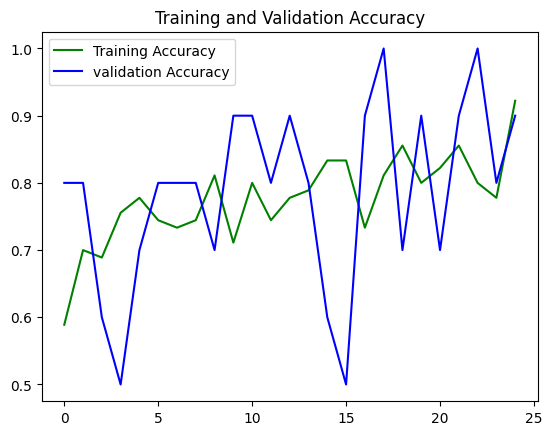

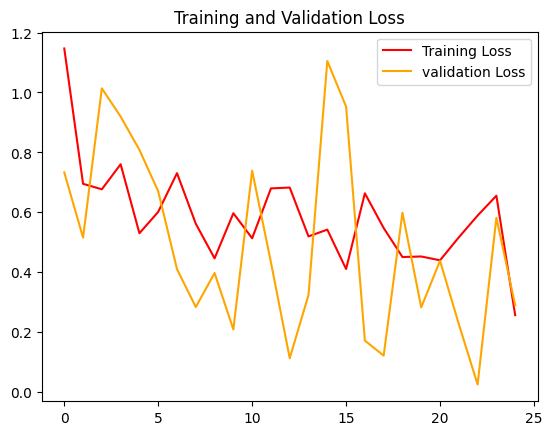

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "validation Loss")
plt.title('Training and Validation Loss')
plt.legend(loc = 'best')
plt.show()

Saving Burger-Train (89).jpeg to Burger-Train (89).jpeg
1/1 [==============================] - 0s 33ms/step
Burger-Train (89).jpeg
Gambar ini adalah hotdog


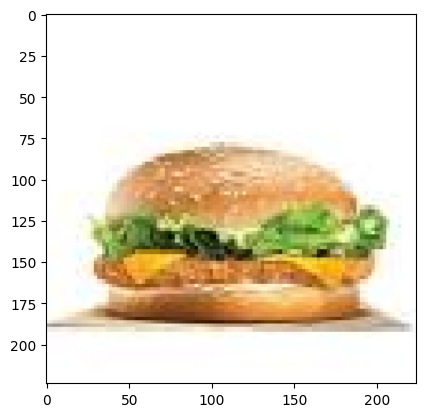

In [ ]:
import keras.utils as image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

for j in range(42):
  if classes[0][j] == 1. :
    print("Gambar ini adalah", class_list[j])
    break

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print("Gambar ini adalah", class_list[j-1])
      break

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print("Gambar ini adalah", class_list[j-1])
      break